# Rotman Data Science Competition
### Section 4.2: A no-brainer implementation to use text-infilling to calculate similarity score between different substitute products
## Imports


In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime

In [2]:
from datasets import Dataset, DatasetDict
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

In [3]:
today_date = datetime.today().strftime('%Y-%m-%d')

DATA_SAVE_PATH = "data/formated_data_for_seq2seq.csv"
CHECKPOINT_SAVE_PATH = f"./substitute_classifier/T5/checkpoint_for_{today_date}"

## Data Preprocessing
### Turning our data into format for text-infilling

In [4]:
REPROCESS_DATA = False
if REPROCESS_DATA:
    DATA_PATH = "./data/mma_mart.csv"
    raw_data = pd.read_csv(DATA_PATH)
    raw_data.head()

In [5]:
if REPROCESS_DATA:
    products = raw_data.loc[:, 'product_id' : 'product_name']
    products.drop_duplicates("product_id", inplace=True)
    products.set_index("product_id", inplace=True)
    raw_data = raw_data.loc[:, 'order_id':'product_name']
    raw_data.head()

In [6]:
if REPROCESS_DATA:
    # Put orders into string format
    FORMAT = "On order {x} a customer bought {item 1, ... , item y}."

    raw_data["str_p_id"] = [f"(id {str(i)})" for i in raw_data["product_id"]]
    raw_data["target_text"] = raw_data["product_name"] + raw_data["str_p_id"]
    # raw_data.drop(columns=["product_id", "product_name", "str_p_id"], inplace=True)
    raw_data.head()

In [7]:
if REPROCESS_DATA:
    # Pick about 15% of the items to mask out
    MASK_RATE = 0.15
    RANDOM_SEED = 42
    random_generator = np.random.default_rng(RANDOM_SEED)
    mask_idx = random_generator.choice(raw_data.index, size= int(raw_data.shape[0] * MASK_RATE), replace=False, axis=0)
    mask_idx[:10]

In [8]:
if REPROCESS_DATA:
    raw_data_masked = raw_data.copy()
    raw_data_masked.loc[mask_idx, "target_text"] = "[MASK]"
    raw_data_masked.head()

In [9]:
if REPROCESS_DATA:
    formated_data = pd.DataFrame(columns=["source_text", "target_text"], index=raw_data.order_id.unique())
    formated_data.head(10)

In [10]:
if REPROCESS_DATA:
    FORMAT = "On order {} a customer bought {}."
    raw_data = raw_data.set_index("order_id")
    raw_data_masked = raw_data_masked.set_index("order_id")
    for idx in raw_data.index.unique():
        items = ", ".join(raw_data.loc[idx]["target_text"])
        items_masked = ", ".join(raw_data_masked.loc[idx]["target_text"])
        formated_data.loc[idx, "target_text"] = FORMAT.format(idx, items)
        formated_data.loc[idx, "source_text"] = FORMAT.format(idx, items_masked)

    formated_data.to_csv(DATA_SAVE_PATH, index=False)

## Data

In [11]:
my_data = pd.read_csv(DATA_SAVE_PATH)
my_data.head()

,source_text,target_text
0,"On order 1 a customer bought [MASK], Organic 4...",On order 1 a customer bought Bulgarian Yogurt(...
1,On order 2 a customer bought Organic Egg White...,On order 2 a customer bought Organic Egg White...
2,On order 3 a customer bought Total 2% with Str...,On order 3 a customer bought Total 2% with Str...
3,"On order 4 a customer bought [MASK], Honey/Lem...",On order 4 a customer bought Plain Pre-Sliced ...
4,On order 5 a customer bought Bag of Organic Ba...,On order 5 a customer bought Bag of Organic Ba...


### 1. Divide into train, eval, and test sets
We use 80% of the data for training, 10% for evaluation, and 10% for testing.

In [12]:
TRAIN_SPLIT_SEED = 42
train_df = my_data.sample(frac = 0.8, random_state=TRAIN_SPLIT_SEED)
eval_df = my_data.drop(train_df.index).sample(frac = 0.5, random_state=TRAIN_SPLIT_SEED)
test_df = my_data.drop(train_df.index).drop(eval_df.index)
train_df.head()

,source_text,target_text
22652,On order 23139 a customer bought Organic Avoca...,On order 23139 a customer bought Organic Avoca...
42695,On order 43680 a customer bought First Prunes(...,On order 43680 a customer bought First Prunes(...
38279,"On order 39159 a customer bought [MASK], Koshe...",On order 39159 a customer bought Organic Diced...
78622,On order 80380 a customer bought Organic Baby ...,On order 80380 a customer bought Organic Baby ...
15252,On order 15570 a customer bought Sharp Cheddar...,On order 15570 a customer bought Sharp Cheddar...


### 2. Create a dataset dict from the dataframes

In [24]:
my_dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "eval": Dataset.from_pandas(eval_df),
    "test": Dataset.from_pandas(test_df),
    })
print(my_dataset.shape)

{'train': (78266, 3), 'eval': (9784, 3), 'test': (9783, 3)}


## Training

### 1. Set model, tokenizer, and data_collator variables

In [25]:
DO_TRAINING = False
if DO_TRAINING:
    CHECKPOINT = "t5-small"
    tokenizer = T5Tokenizer.from_pretrained(CHECKPOINT)
    model = T5ForConditionalGeneration.from_pretrained(CHECKPOINT)
    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

### 2. Down sample the dataset to 10,000 examples for training, 1,000 for evaluation, and 1,000 for testing for the sake of fast training

In [26]:
if DO_TRAINING:
    train_size = 10000
    test_size = train_size // 10
    eval_size = train_size // 10

    down_sampled_ds = my_dataset["train"].train_test_split(train_size=train_size, test_size=test_size + eval_size, seed=TRAIN_SPLIT_SEED)
    test_valid = down_sampled_ds["test"].train_test_split(train_size=eval_size, test_size=test_size, seed=TRAIN_SPLIT_SEED)
    down_sampled_ds["eval"] = test_valid["train"]
    down_sampled_ds["test"] = test_valid["test"]

### 3. Tokenize the dataset

In [27]:
if DO_TRAINING:
    MAX_LENGTH = 512
    def tokenize(source_texts, target_texts):
        model_inputs = tokenizer(text=source_texts, max_length=MAX_LENGTH, truncation=True)
        labels = tokenizer(text_target=target_texts, max_length=MAX_LENGTH, truncation=True)
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs
    tokenized_dataset = down_sampled_ds.map(tokenize, input_columns=["source_text", "target_text"], remove_columns=["source_text", "target_text"])

### 4. Set training arguments
Change "output_directory" to your desired output directory. You can also change the batch_size, learning_rate, num_train_epochs and other parameters here. See the documentation for more details: [https://huggingface.co/docs/transformers/v4.21.3/en/main_classes/trainer#transformers.TrainingArguments](https://huggingface.co/docs/transformers/v4.21.3/en/main_classes/trainer#transformers.TrainingArguments)

In [28]:
if DO_TRAINING:
    if torch.cuda.is_available():
        training_arguments = Seq2SeqTrainingArguments(
            "output_directory",
            learning_rate=0.0001,
            weight_decay=0.01,
            fp16=True,
            per_device_train_batch_size=4,
            per_device_eval_batch_size=4,
            gradient_accumulation_steps=2,
            num_train_epochs=20,
            evaluation_strategy="epoch",
            report_to="all"
        )
    elif torch.backends.mps.is_available():
        mps_device = torch.device("mps")
        torch.mps.set_per_process_memory_fraction(0.0)

        training_arguments = Seq2SeqTrainingArguments(
            "output_directory",
            learning_rate=0.0001,
            weight_decay=0.01,
            per_device_train_batch_size=4,
            per_device_eval_batch_size=4,
            gradient_accumulation_steps=2,
            num_train_epochs=20,
            evaluation_strategy="epoch",
            report_to="all"
        )
    else:
        training_arguments = Seq2SeqTrainingArguments(
            "output_directory",
            learning_rate=0.0001,
            weight_decay=0.01,
            per_device_train_batch_size=4,
            per_device_eval_batch_size=4,
            gradient_accumulation_steps=2,
            num_train_epochs=20,
            evaluation_strategy="epoch",
            report_to="all"
        )

### 5. Create a trainer

In [29]:
if DO_TRAINING:
    trainer = Seq2SeqTrainer(
        model,
        training_arguments,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["eval"],
        data_collator=data_collator,
        tokenizer=tokenizer
    )

In [30]:
torch.cuda.is_available()

False

### 6. Train the model

In [31]:
if DO_TRAINING:
    trainer.train()

## Evaluate

In [40]:
CHECKPOINT_SAVE_PATH = "./substitute_classifier/T5/checkpoint_for_2023-10-01"
model = T5ForConditionalGeneration.from_pretrained(CHECKPOINT_SAVE_PATH)
tokenizer = T5Tokenizer.from_pretrained(CHECKPOINT_SAVE_PATH, padding_side="left")

In [41]:
input_text = my_dataset["test"]['source_text'][0:10]
target_text = my_dataset["test"]['target_text'][0:10]

In [42]:
device = torch.device("mps")
model = model.to(device)

In [68]:
%%time
input_ids = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)
input_ids = input_ids.to(device)

CPU times: user 5.71 ms, sys: 2.58 ms, total: 8.29 ms
Wall time: 933 ms


In [69]:
%%time
output_ids = model.generate(input_ids['input_ids'], max_length=512, num_beams=5, do_sample=True, num_return_sequences=1)

CPU times: user 23.5 s, sys: 14.9 s, total: 38.4 s
Wall time: 39.7 s


In [70]:
%%time
all_output = tokenizer.batch_decode(output_ids)

CPU times: user 47.4 ms, sys: 4.45 ms, total: 51.9 ms
Wall time: 976 ms


In [71]:
all_output_df = pd.DataFrame(all_output, columns=["output"])
all_output_df["target"] = target_text
all_output_df["input"] = input_text
all_output_df = all_output_df[["input", "target", "output"]]

In [72]:
def get_substitute_score(input_text, target, candidate) -> float:
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    target_input_id = tokenizer(target, return_tensors="pt").input_ids
    candidate_input_id = tokenizer(candidate, return_tensors="pt").input_ids
    # true_loss = model(input_ids = input_ids, labels = target_input_id)
    true_loss = model(input_ids = input_ids, labels = target_input_id).loss.item()
    candidate_loss = model(input_ids = input_ids, labels = candidate_input_id).loss.item()
    print(true_loss, candidate_loss)
    return (1-candidate_loss)/(1-true_loss)

In [73]:
all_output_df

,input,target,output
0,On order 6 a customer bought Cleanse(id 40462)...,On order 6 a customer bought Cleanse(id 40462)...,<pad> On order 6 a customer bought Cleanse(id ...
1,On order 16 a customer bought Original Popcorn...,On order 16 a customer bought Original Popcorn...,<pad> On order 16 a customer bought Original P...
2,On order 22 a customer bought 2% Reduced Fat M...,On order 22 a customer bought 2% Reduced Fat M...,<pad> On order 22 a customer bought 2% Reduced...
3,On order 40 a customer bought Organic 1% Low F...,On order 40 a customer bought Organic 1% Low F...,<pad> On order 40 a customer bought Organic 1%...
4,"On order 45 a customer bought O, r, g, a, n, i...","On order 45 a customer bought O, r, g, a, n, i...","<pad> On order 45 a customer bought O, r, g, a..."
5,On order 48 a customer bought Organic Chicken ...,On order 48 a customer bought Organic Chicken ...,<pad> On order 48 a customer bought Organic Ch...
6,"On order 51 a customer bought [MASK], Milk Who...",On order 51 a customer bought Artesano Style B...,<pad> On order 51 a customer bought Organic Ba...
7,On order 53 a customer bought Banana(id 24852)...,On order 53 a customer bought Banana(id 24852)...,<pad> On order 53 a customer bought Banana(id ...
8,"On order 59 a customer bought [MASK], Chopped ...",On order 59 a customer bought Prepared Meals S...,<pad> On order 59 a customer bought Organic Wh...
9,On order 63 a customer bought Wild Blend Rice(...,On order 63 a customer bought Wild Blend Rice(...,<pad> On order 63 a customer bought Wild Blend...


In [74]:
# Remove redundant text and show the substitute identified
all_output_df["output"] = all_output_df["output"].str.replace("On order \d+ a customer bought ", "")
all_output_df["target"] = all_output_df["target"].str.replace("On order \d+ a customer bought ", "")
all_output_df["input"] = all_output_df["input"].str.replace("On order \d+ a customer bought ", "")

# Remove padding tokens
all_output_df["output"] = all_output_df["output"].str.replace("<pad>", "")

all_output_df

,input,target,output
0,"Cleanse(id 40462), Dryer Sheets Geranium Scent...","Cleanse(id 40462), Dryer Sheets Geranium Scent...","Cleanse(id 40462), Dryer Sheets Geranium Scen..."
1,"Original Popcorn(id 9755), Water(id 25466), Se...","Original Popcorn(id 9755), Water(id 25466), Se...","Original Popcorn(id 9755), Water(id 25466), S..."
2,"2% Reduced Fat Milk(id 23909), Butter Top Whit...","2% Reduced Fat Milk(id 23909), Butter Top Whit...","2% Reduced Fat Milk(id 23909), Butter Top Whi..."
3,"Organic 1% Low Fat Milk(id 10070), Macaroni & ...","Organic 1% Low Fat Milk(id 10070), Macaroni & ...","Organic 1% Low Fat Milk(id 10070), Macaroni &..."
4,"O, r, g, a, n, i, c, , Y, a, m, s, (, i, d, ...","O, r, g, a, n, i, c, , Y, a, m, s, (, i, d, ...","O, r, g, a, n, i, c,, Y, a, m, s, (, i, d,, 1..."
5,"Organic Chicken Bone Broth(id 14129), Yo Baby ...","Organic Chicken Bone Broth(id 14129), Yo Baby ...","Organic Chicken Bone Broth(id 14129), Yo Baby..."
6,"[MASK], Milk Whole(id 3594), Baby Dynamic Duo ...","Artesano Style Bread(id 30274), Milk Whole(id ...","Organic Baby Spinach(id 21903), Milk Whole(id..."
7,"Banana(id 24852), Organic Gala Apples(id 37646...","Banana(id 24852), Organic Gala Apples(id 37646...","Banana(id 24852), Organic Gala Apples(id 3764..."
8,"[MASK], Chopped Blends With Beef, Carrots, Pea...",Prepared Meals Simmered Chicken Medley Wet Dog...,"Organic Whole Milk(id 27845), Chopped Blends ..."
9,"Wild Blend Rice(id 25886), Reduced-fat Soft Cr...","Wild Blend Rice(id 25886), Reduced-fat Soft Cr...","Wild Blend Rice(id 25886), Reduced-fat Soft C..."


In [53]:
training_info = pd.read_csv("substitute_classifier/T5/training_data.csv")
training_info.head()

,Epoch,Training Loss,Validation Loss
0,1,0.3924,0.368313
1,2,0.3561,0.338654
2,3,0.3395,0.320604
3,4,0.3166,0.306147
4,5,0.2990,0.295683


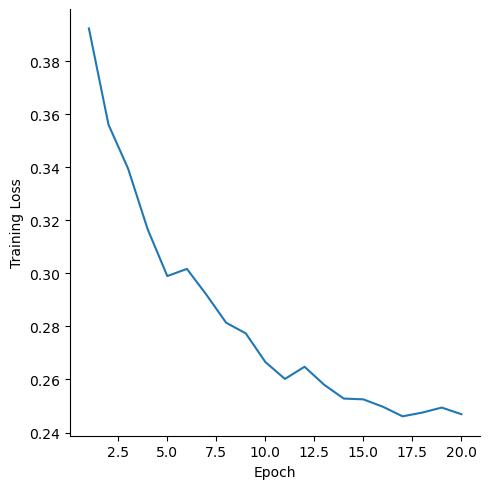

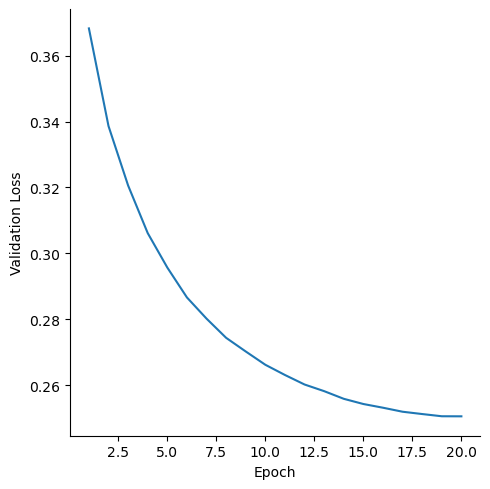

In [66]:
# import warnings
# warnings.filterwarnings('ignore')
sns.relplot(data=training_info, x="Epoch", y="Training Loss", kind="line")
sns.relplot(data=training_info, x="Epoch", y="Validation Loss", kind="line")

In [ ]:
# input_text = input_text[5]
# target_text = target_text[5]
# get_substitute_score(input_text, target_text, all_output[5])
